# Algoritmo Genético na descoberta de soluções para X e Y disponibilizadas pelo professor
## Produzido por: Gabriel dos Santos Sereno

In [51]:
import time
import random
import math
import matplotlib.pyplot as plt
import collections as cl
import numpy as np
from tabulate import tabulate

#Retorna o tamanho do estado
def Get_State_Size(state):
    return sum(state)

#Retorna a classificassao mais frequente da base
def Get_Most_Frequent(column, baseFrequencies):
    frequencies = cl.Counter(column).items()
    betterFrequency = 0
    better = None

    for key, value in frequencies:
        if(value > betterFrequency):
            better = key
            betterFrequency = value
        elif(value == betterFrequency):
            for selfKey, selfValue in baseFrequencies.most_common():
                if(selfKey == better):
                    break
                if(selfKey == key):
                    better = key
                    betterFrequency = value
    return better

#valida os resultados dos classificadores
def Evaluate_State(state, data, target):
    result = 0

    for i in range(len(data)):
        result += (target[i] - ((state[2] * (data[i] ** 2) ) + (state[1] * data[i]) + state[0])) ** 2

    return result / len(data)

#Retorna os valores da populacao
def Evaluate_Population (pop, data, target):
    eval = []
    for s in pop:
        eval = eval + [(Evaluate_State(s, data, target), s)]
    return eval

#Retorna o valor total dos estados
def Get_States_Total_Value(states):
    total_sum = 0
    for state in states:
        total_sum = total_sum + state[0]
    return total_sum

#Funcao que constroi da roleta
def Roulette_Construction(states):
    aux_states = []
    roulette = []
    total_value = Get_States_Total_Value(states)

    for state in states:
        value = state[0]
        if total_value != 0:
            ratio = 1 - (value/total_value)
        else:
            ratio = 1
        aux_states.append((ratio,state[1]))

    total_aux_value = Get_States_Total_Value(aux_states)

    for i,state in enumerate(aux_states):
        value = state[0]
        if total_value != 0:
            ratio = value/total_aux_value
        else:
            ratio = 1

        aux_states[i] = (ratio,state[1])

    acc_value = 0
    for state in aux_states:
        acc_value = acc_value + state[0]
        s = (acc_value,state[1])
        roulette.append(s)

    return roulette

#Funcao da roleta
def Roulette_Run (rounds, roulette):
    if roulette == []:
        return []
    selected = []
    while len(selected) < rounds:
        r = random.uniform(0,1)
        for state in roulette:
            if r <= state[0]:
                selected.append(state[1])
                break
    return selected

def First(x):
    return x[0]

#Retorna os novos estados
def Get_Selection(value_population,n):
    aux_population = Roulette_Construction(value_population)
    new_population = Roulette_Run(n, aux_population)
    return new_population

#Faz o crossover
def Get_Crossover(dad,mom):
    r = random.randint(0, len(dad) - 1)
    son = dad[:r]+mom[r:]
    daug = mom[:r]+dad[r:]
    return son, daug

#Retorna a mutacao
def Get_Mutation (indiv):
    individual = indiv.copy()
    rand = random.randint(0, len(individual) - 1)

    while sum(individual) == 0:
        individual[rand] = random.uniform(-5, 5)

    return individual

#Gera a populacao inciial
def Get_Initial_Population(n, nr_Length = 3):
    pop = []
    count = 0
    while count < n:
        individual = [0, 0, 0]

        while sum(individual) == 0:
            individual = [random.uniform(-5, 5) for i in range(nr_Length)]

        pop = pop + [individual]
        count += 1
    return pop

#Faz a convergencia da populacao
def Get_Convergent(population):
    conv = False
    if population != []:
        base = population[0]
        i = 0
        while i < len(population):
            if base != population[i]:
                return False
            i += 1
        return True

#Retorna as classes atraves do elitismo
def Get_Elitism (val_pop, pct):
    n = math.floor((pct/100)*len(val_pop))
    if n < 1:
        n = 1
    val_elite = sorted (val_pop, key = First)[:n]
    elite = [s for v,s in val_elite]
    return elite

#Funcao que retorna o crossover
def Get_Crossover_Step (population, crossover_ratio):
    new_pop = []

    for _ in range (round(len(population)/2)):
        rand = random.uniform(0, 1)
        fst_ind = random.randint(0, len(population) - 1)
        scd_ind = random.randint(0, len(population) - 1)
        parent1 = population[fst_ind]
        parent2 = population[scd_ind]

        if rand <= crossover_ratio:
            offspring1, offspring2 = Get_Crossover(parent1, parent2)

            if Get_State_Size(offspring1) == 0:
                print("Erro")
                offspring1 = parent1
            if Get_State_Size(offspring2) == 0:
                print("Erro")
                offspring2 = parent2
        else:
            offspring1, offspring2 = parent1, parent2

        new_pop = new_pop + [offspring1, offspring2]

    return new_pop

#Faz a mutacao
def Get_Mutation_Step (population, mutation_ratio):
    ind = 0
    for individual in population:
        rand = random.uniform(0, 1)

        if rand <= mutation_ratio:
            mutated = Get_Mutation(individual)
            if Get_State_Size(mutated) > 0:
                population[ind] = mutated

        ind+=1

    return population

#Parte principal do algoritmo
def Genetic (nr_Length, data, target, pop_size, max_iter, cross_ratio, mut_ratio, max_time, elite_pct):
    start = time.process_time()
    opt_state = [0] * nr_Length
    opt_value = np.Infinity
    pop = Get_Initial_Population(pop_size, nr_Length)
    conv = Get_Convergent(pop)
    iter = 0
    end = 0

    while not conv and iter < max_iter and end-start <= max_time:
        val_pop = Evaluate_Population (pop, data, target)
        new_pop = Get_Elitism (val_pop, elite_pct)
        best = new_pop[0]
        val_best = Evaluate_State(best, data, target)

        if (val_best < opt_value):
            opt_state = best
            opt_value = val_best

        selected = Get_Selection(val_pop, pop_size - len(new_pop))
        crossed = Get_Crossover_Step(selected, cross_ratio)
        mutated = Get_Mutation_Step(crossed, mut_ratio)
        pop = new_pop + mutated
        conv = Get_Convergent(pop)
        iter+=1
        end = time.process_time()


    return float(opt_state[0]), float(opt_state[1]), float(opt_state[2]), float(opt_value)

In [52]:
with open('x_data.txt') as f:
    lines = f.readlines()

data = np.array([float(x.strip()) for x in lines])

with open('y_data.txt') as f:
    lines = f.readlines()

target = np.array([float(x.strip()) for x in lines])

In [53]:
results = []

for i in range(10):
    results.append(Genetic(3, data, target, 200, 100, 0.9, 0.1, 120, 5))

table = tabulate(results, headers=['C', 'B', 'A', 'Erro obtido'], floatfmt=".3f")

print(table)

     C       B       A    Erro obtido
------  ------  ------  -------------
 0.330   1.300  -0.388          0.005
 1.557  -0.091   0.018          0.178
-0.033   1.915  -0.582          0.043
-0.571   2.016  -0.529          0.173
 0.476   0.204   0.014          0.156
-0.275   2.607  -0.864          0.177
 0.526   1.191  -0.401          0.025
-0.284   1.774  -0.434          0.099
 0.591   0.603  -0.098          0.042
-0.074   1.979  -0.623          0.068


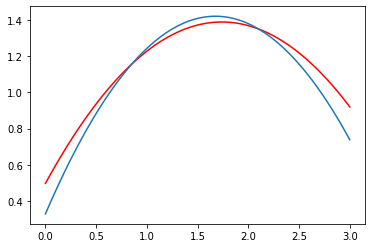

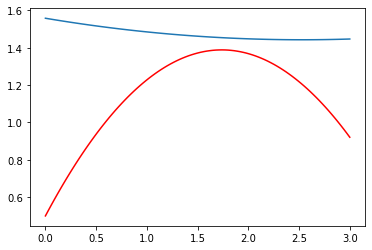

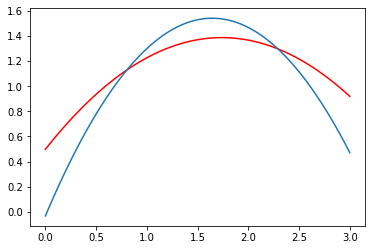

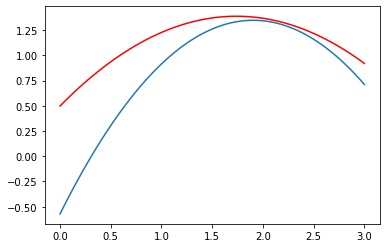

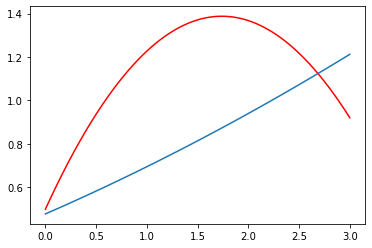

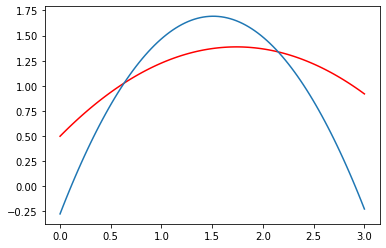

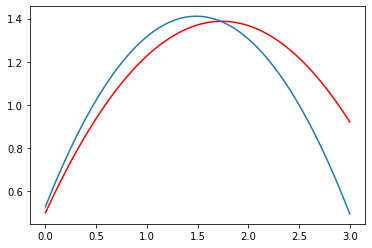

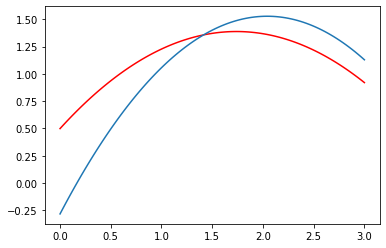

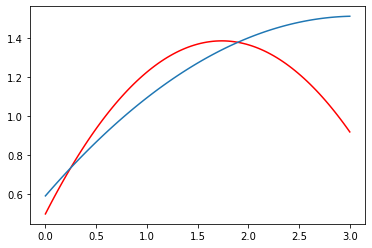

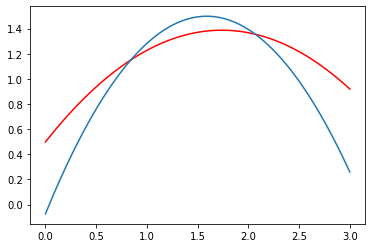

In [55]:
for i in results:
    plt.plot(data, target, 'r-')
    plt.plot(data, i[1]*data + i[2]*data**2 + i[0])
    plt.show()